# Challenge Deep Learning

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images de champignons.
Le jeu de données proposé comprend 3 classes balancées

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Vous devez prendre en compte la spécificité des données (peu d'exemples, images de tailles différentes,...) pour construire vos jeux d'apprentissage et de test.

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur une base que nous conservons, pour voir si les résultats que vous proposez sont reproductibles. 

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous **expliquerez votre démarche**, **justifierez vos choix**, **commenterez vos expérimentations et vos résultats**.

La notation sera construite de la manière suivante : 
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test. 

Le notebook sera déposé sur la plateforme moodle du cours.

In [44]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# importation utile des tps précédents
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import  \
    Input, Dense, Activation,Lambda, \
    Flatten,Dropout,Conv2D, Dropout, \
    MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split




In [ ]:
def load_data():
    #with zipfile.ZipFile('./datasets/mushrooms.zip', 'r') as zip:
    #    zip.extractall('./datasets')
    
    data_dir = os.path.join("datasets","mushrooms")
    classes = os.listdir(data_dir)
    print("Classes:", classes)
    
    data_list = []
    for label in classes:
        image_files = os.listdir(os.path.join(data_dir,label))
        # On filtres les images qui n'ont pas lieu d'être dans la BDD
        data_list.extend([(label,os.path.join(data_dir,label,f)) for f in image_files if not "x" in f])

    print("Nombre d'images total:",len(data_list))
    print("Nombre d'images par classes:",[len(os.listdir(os.path.join(data_dir,label))) for label in classes])
    
    return data_list, classes

In [46]:
data_list, classes = load_data()
(data_list, classes)

Classes: ['amanita', 'crimini', 'oyster']
Nombre d'images total: 1590
Nombre d'images par classes: [535, 561, 547]


([('amanita', 'datasets\\mushrooms\\amanita\\0.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\1.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\10.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\100.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\101.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\102.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\103.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\105.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\106.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\107.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\108.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\109.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\11.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\111.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\112.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\113.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\114.jpg'),
  ('amanita', 'datasets\\mushrooms\\amanita\\115.jpg')

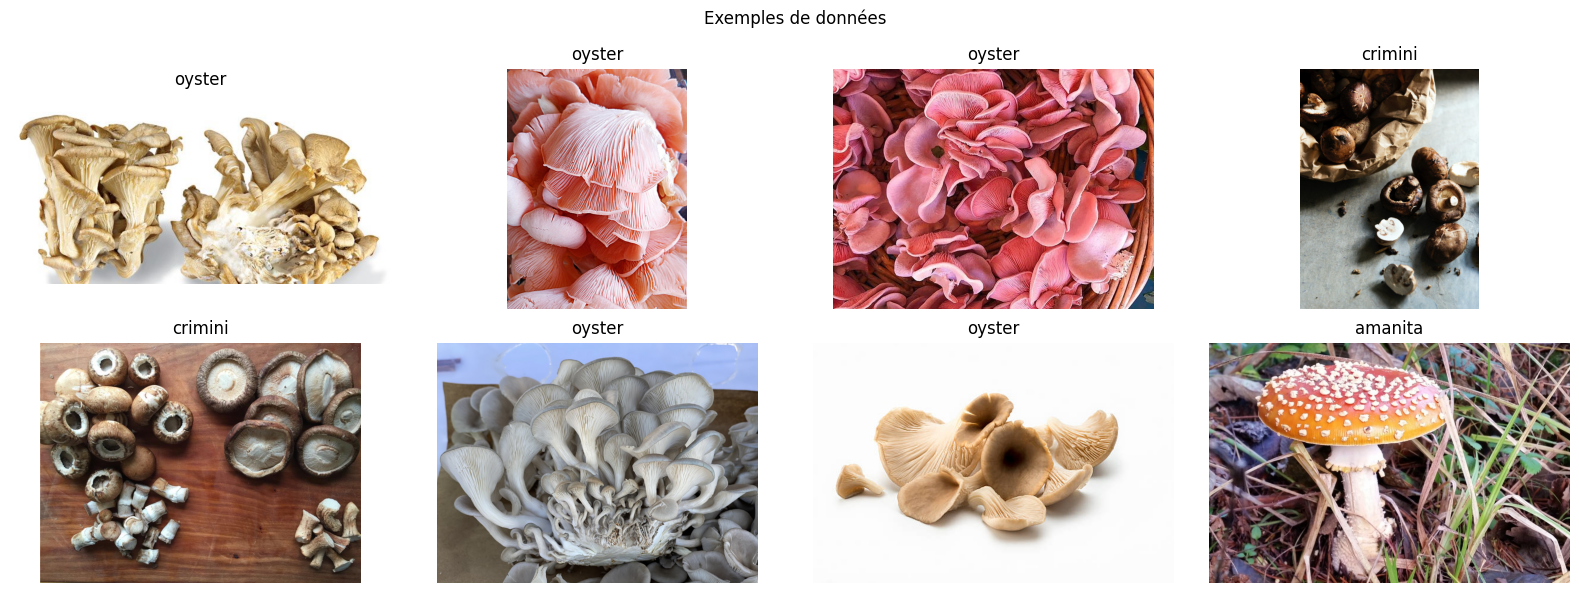

In [47]:
image_samples = np.random.randint(0,high=len(data_list)-1, size=8)

fig = plt.figure(figsize=(16,6))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(2,4,i+1)
    axs.set_title(data_list[img_idx][0])
    image = Image.open(data_list[img_idx][1])
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Exemples de données")
plt.tight_layout()

Model

In [48]:
num_epochs = 16
batch_size = 64
img_size = (128, 128)

In [49]:
def preprocess_data(data_list, classes, img_size=img_size):
    X = []
    y = []
    label_map = {label: idx for idx, label in enumerate(classes)}

    for label, img_path in data_list:
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(img_size)
            X.append(np.array(img))
            y.append(label_map[label])
        except Exception as e:
            print(f"Erreur lors du traitement de {img_path}: {e}")

    X = np.array(X, dtype=np.float32) / 255.0  # Normalisation
    y = np.array(y)
    y = to_categorical(y, num_classes=len(classes))  # One-hot encoding
    return X, y

In [50]:
# Construction du modèle CNN
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation=tf.nn.relu, input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation=tf.nn.relu),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation=tf.nn.relu),
        Dropout(0.5),
        Dense(num_classes, activation=tf.math.softmax),
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Classes: ['amanita', 'crimini', 'oyster']
Nombre d'images total: 1590
Nombre d'images par classes: [535, 561, 547]


c:\Users\TTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
c:\Users\TTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,707 (28.20 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - accuracy: 0.3304 - loss: 3.2557 - val_accuracy: 0.3585 - val_loss: 1.0985
Epoch 2/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.3312 - loss: 1.0979 - val_accuracy: 0.3711 - val_loss: 1.0882
Epoch 3/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step - accuracy: 0.3945 - loss: 1.0734 - val_accuracy: 0.5409 - val_loss: 1.0344
Epoch 4/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 314ms/step - accuracy: 0.5390 - loss: 0.9811 - val_accuracy: 0.5063 - val_loss: 1.0255
Epoch 5/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 326ms/step - accuracy: 0.5835 - loss: 0.9203 - val_accuracy: 0.6069 - val_loss: 0.9320
Epoch 6/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.6153 - loss: 0.8179 - val_accuracy: 0.6258 - val_loss: 0.8956
Epoch 7/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.6977 - loss: 0.7566 - val_accuracy: 0.6352 - val_loss: 0.8664
Epoch 8/16
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 326ms/step - accuracy: 0.7274 - loss: 0.6549 - val_accuracy: 0.

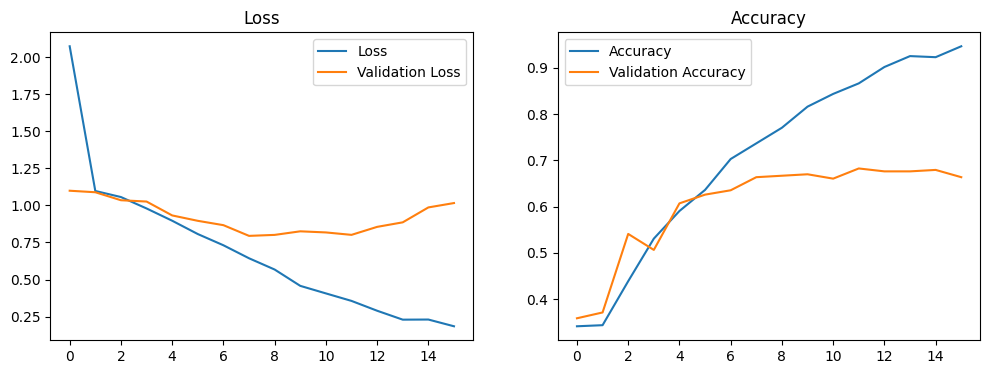

In [51]:
# Chargement et traitement des données
data_list, classes = load_data()
X, y = preprocess_data(data_list, classes)

# Division des données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle
model = create_model(input_shape=X.shape[1:], num_classes=len(classes))
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=1
)

# Évaluation des performances
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Visualisation des courbes d'entraînement
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.show()